In [1]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import json
import cProfile

# A Parallel Code for the Argon System using the Verlet Algorithm and the Lennard-Jones Potential

This notebook summarizes the results of the parallelization of the Argon system using the Varlet algorithm and the Lennard-Jones potential. As a part of the 3rd Latinoamerican School of High Performance Computing, we were asked to parallelize the code using MPI and OpenMP.

The goal of this implementation are the following:

1. Take an improved reading of the input data, compared with C++ code.
2. Obtain a likely C speedup of the code, by using a join of C scripts and Python scripts.
3. Receive the output data in a more friendly way, by using Python scripts.
4. Make an animation of the system, by using Python scripts.

## First step: Basics

The most basic implementation of the Argon system is the sequential code. Remember at this point that the Argon system is a set of particles that interact with each other by using the Lennard-Jones potential. The potential follows:

$$ V(r) = 4 \epsilon_{ij} \left[ \left( \frac{\sigma_{ij}}{r} \right)^{12} - \left( \frac{\sigma_{ij}}{r} \right)^{6} \right] $$

where $r$ is the distance between two particles, $\epsilon_{ij}$ is the depth of the potential well, and $\sigma_{ij}$ is the distance at which the inter-particle potential is zero. The values of $\epsilon_{ij}$ and $\sigma_{ij}$ are given by:

$$ \frac{\epsilon_{ij}}{k} = 119.8, \quad \frac{\sigma_{ij}}{\AA} = 3.405 $$

Therefore, the force between two particles is given by:

$$ \vec{F}_{ij} = - \nabla V(r) = \frac{24 \epsilon_{ij}}{r} \left[ 2 \left( \frac{\sigma_{ij}}{r} \right)^{12} - \left( \frac{\sigma_{ij}}{r} \right)^{6} \right] \hat{r} $$

where $\vec{r}$ is the vector that goes from particle $i$ to particle $j$.

### The Verlet algorithm

The Verlet algorithm is a numerical method to solve the equations of motion of a system. The algorithm is based on the Taylor expansion of the position of a particle:

$$ \vec{r}(t+\delta t) = \vec{r}(t) + \vec{v}(t) \delta t + \frac{1}{2} \vec{a}(t) \delta t^2 + \mathcal{O}(\delta t^3) $$

where $\vec{r}(t)$ is the position of the particle at time $t$, $\vec{v}(t)$ is the velocity of the particle at time $t$, $\vec{a}(t)$ is the acceleration of the particle at time $t$, and $\delta t$ is the time step. The Verlet algorithm has a velocity update of the form:

$$ \vec{v}(t+\delta t) = \vec{v}(t) + \frac{1}{2} \left[ \vec{a}(t) + \vec{a}(t+\delta t) \right] \delta t + \mathcal{O}(\delta t^3) $$

where $\vec{a}(t)$ is the acceleration of the particle at time $t$, and $\vec{a}(t+\delta t)$ is the acceleration of the particle at time $t+\delta t$.

## Second step: A sequential code

Let's start with a sequential code of this problem written in Python:

### Read inputs from a non-parallel way

To read the input, we will use a json file. The file is called `input.json` and it is located in the `data` folder. The file has the following structure:

```json
{
    "n_particles": 108,
    "mass": 39.948,
    "epsilon": 0.2379,
    "sigma": 3.405,
    "r_cut": 8.5,
    "box_size": 17.1580,
    "initial_state": "argon_108.rest",
    "trajectory_file": "argon_108.xyz",
    "energy_file": "argon_108.dat",
    "n_steps": 1000,
    "delta_t": 5,
    "output_freq": 10
}
```

In [2]:
with open('input_2916.json') as f:
    data = json.load(f)

# print the initial input
print(data)

{'n_particles': 2916, 'mass': 39.948, 'epsilon': 0.2379, 'sigma': 3.405, 'r_cut': 12.0, 'box_size': 51.474, 'initial_state': 'argon_2916.rest', 'trajectory_file': 'argon_2916.xyz', 'energy_file': 'argon_2916.dat', 'n_steps': 100, 'delta_t': 5, 'output_freq': 10, 'n_workers': 4}


Then, to read the rest positions of the particles, we will use a plain-text file with ending of .rest, it will contain all the positions x, y, z of the particles. The file is called using the json file, and it is located in the `data` folder. The same idea occurs for the energy and positions files.

In [3]:
# read initial positions using numpy, from the json file
with open(f"data/{data['initial_state']}") as initial_state:
    x_i, y_i, z_i = np.genfromtxt(initial_state, unpack=True, max_rows=data['n_particles'])

print(x_i.shape, y_i.shape, z_i.shape)

(2916,) (2916,) (2916,)


Plotting the initial positions seems like:

Text(0.5, 0, 'z')

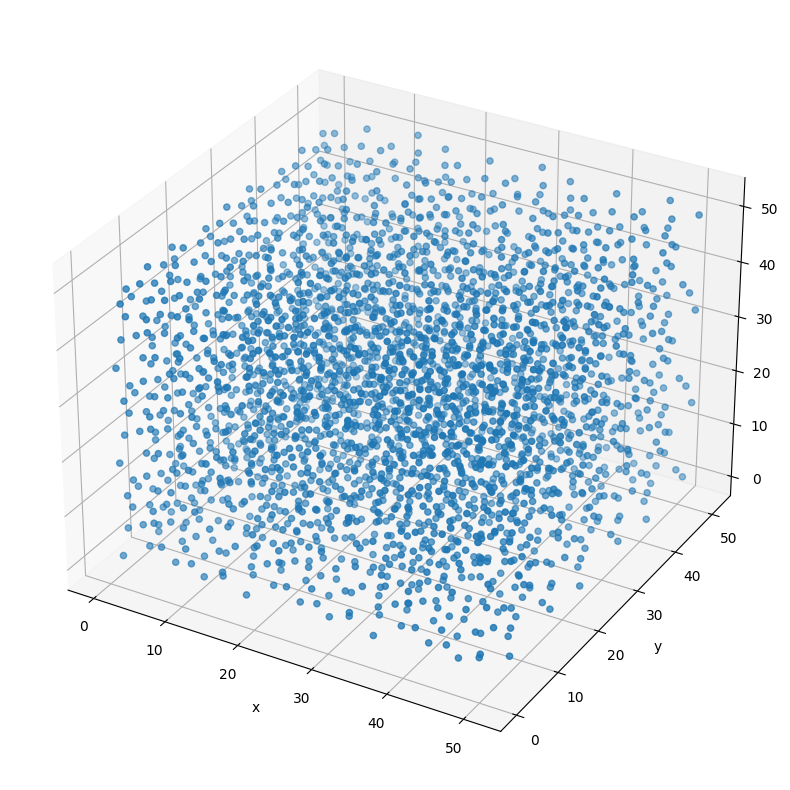

In [27]:
fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, figsize=(10, 10))
ax.scatter(x_i, y_i, z_i)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

Let's define the variables that allocates the positions, velocities and forces of the particles, for every time step.

In [4]:
x_s = np.zeros((data['n_steps'], data['n_particles']))
y_s = np.zeros((data['n_steps'], data['n_particles']))
z_s = np.zeros((data['n_steps'], data['n_particles']))
vx_s = np.zeros((data['n_steps'], data['n_particles']))
vy_s = np.zeros((data['n_steps'], data['n_particles']))
vz_s = np.zeros((data['n_steps'], data['n_particles']))
fx_s = np.zeros((data['n_steps'], data['n_particles']))
fy_s = np.zeros((data['n_steps'], data['n_particles']))
fz_s = np.zeros((data['n_steps'], data['n_particles']))

same task, but for kinetic energy, potential energy, and temperature.

In [5]:
kinetic_energy = np.zeros(data['n_steps'])
potential_energy = np.zeros(data['n_steps'])
temperature = np.zeros(data['n_steps'])

each step, we will add the positions, velocities and forces to the corresponding array. Let's start with the initial positions (remember that, at rest, the velocities are zero):

In [6]:
x_s[0] = x_i
y_s[0] = y_i
z_s[0] = z_i

### Calculate the forces

Now, it is needed to set a function that calculates the forces between the particles. The function will receive the positions of the particles, and will return the forces between the particles. The function is:

In [7]:
def lj_force_looping(x, y, z):
    fx, fy, fz, potential_energy = [0] * len(x), [0] * len(x), [0] * len(x), 0
    def pbc(r, box_size_by_2):
        """ Minimum image convention
        In this approach, the box have a length 2 * box_size_by_2, and if it is outside the box divided by 2, it is moved to the other side of the box, to avoid wall effects. See: https://www.ucl.ac.uk/~ucfbasc/Theory/pbc-mi.html
        
        It is required to have a cutoff radius lower than box_size_by_2.
        
        :param r: Position of the particle, can be x, y or z.
        :param box_size_by_2: Half of the box size.
        :return: The position of the particle, with the minimum image convention.
        """
        while r > box_size_by_2:
            r -= 2 * box_size_by_2
        while r < -box_size_by_2:
            r += 2 * box_size_by_2
        return r
    c12 = 4 * data['epsilon'] * (data['sigma']**12)
    c6 = 4 * data['epsilon'] * (data['sigma']**6)
    r_cut2 = data['r_cut'] * data['r_cut']
    for i in range(0, data['n_particles']):
        for j in range(i+1, data['n_particles']):
            if i != j:
                dx = pbc(x[i] - x[j], data['box_size'] * 0.5)
                dy = pbc(y[i] - y[j], data['box_size'] * 0.5)
                dz = pbc(z[i] - z[j], data['box_size'] * 0.5)
                r2 = dx*dx + dy*dy + dz*dz
                
                if r2 < r_cut2:
                    r2_inv = 1.0 / r2
                    r6_inv = r2_inv * r2_inv * r2_inv
                    f_aux = (12.0 * c12 * r6_inv - 6.0 * c6) * r6_inv * r2_inv
                    potential_energy += (c12 * r6_inv - c6) * r6_inv
                    fx[i] += f_aux * dx
                    fy[i] += f_aux * dy
                    fz[i] += f_aux * dz
                    # Take into account 3rd Newton's law
                    fx[j] -= f_aux * dx
                    fy[j] -= f_aux * dy
                    fz[j] -= f_aux * dz
    return fx, fy, fz, potential_energy

As you can see, there are some improvements over the normal evaluation of the function, specifically:
1. The operations involving powers were reduced to multiplications, if possible.
2. The forces calculation takes into account the 3rd Newton's law, so the forces are calculated only once.

In python, by using numpy arrays, it is possible to vectorize the function, so it can be evaluated faster (in theory). The vectorized function is:

In [8]:
def lj_force_vectorized(x, y, z):
    # calculate the distance between the particles
    dx = x[:, np.newaxis] - x[np.newaxis, :]
    dy = y[:, np.newaxis] - y[np.newaxis, :]
    dz = z[:, np.newaxis] - z[np.newaxis, :]
    # apply the minimum image convention
    dx = dx - data['box_size'] * np.round(dx / data['box_size'])
    dy = dy - data['box_size'] * np.round(dy / data['box_size'])
    dz = dz - data['box_size'] * np.round(dz / data['box_size'])
    # calculate the distance between the particles
    r2 = dx*dx + dy*dy + dz*dz
    # set the conditions for the force
    rcut2 = data['r_cut'] * data['r_cut']
    conditions = np.logical_and(0.001 < r2, r2 < rcut2)
    # calculate the force
    c12 = 4 * data['epsilon'] * (data['sigma']**12)
    c6 = 4 * data['epsilon'] * (data['sigma']**6)
    r2_inv = 1.0 / r2
    r6_inv = r2_inv * r2_inv * r2_inv
    f_aux = (12.0 * c12 * r6_inv - 6.0 * c6) * r6_inv * r2_inv
    # apply the conditions
    f_aux[~conditions] = 0
    # calculate the potential energy
    potential_energy = (c12 * r6_inv - c6) * r6_inv
    potential_energy[~conditions] = 0
    # return the forces and the potential energy
    return np.sum(f_aux * dx, axis=1), np.sum(f_aux * dy, axis=1), np.sum(f_aux * dz, axis=1), 0.5 * np.sum(potential_energy)

Let's do some testing and check if the output of both functions are similar, between some tolerance level:

In [33]:
cProfile.run('lj_force_vectorized(x_s[0], y_s[0], z_s[0])')

/tmp/ipykernel_53189/3589373895.py:18: RuntimeWarning: divide by zero encountered in divide
  r2_inv = 1.0 / r2


         99 function calls (96 primitive calls) in 0.660 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.582    0.582    0.655    0.655 3589373895.py:1(lj_force_vectorized)
        3    0.000    0.000    0.045    0.015 <__array_function__ internals>:177(around)
        3    0.000    0.000    0.045    0.015 <__array_function__ internals>:177(round_)
        4    0.000    0.000    0.028    0.007 <__array_function__ internals>:177(sum)
        1    0.005    0.005    0.660    0.660 <string>:1(<module>)
        4    0.000    0.000    0.000    0.000 fromnumeric.py:2157(_sum_dispatcher)
        4    0.000    0.000    0.028    0.007 fromnumeric.py:2162(sum)
        6    0.000    0.000    0.000    0.000 fromnumeric.py:3210(_around_dispatcher)
        3    0.000    0.000    0.045    0.015 fromnumeric.py:3214(around)
        3    0.000    0.000    0.045    0.015 fromnumeric.py:3722(round_)
        3    0.000    0.000   

In [34]:
cProfile.run('lj_force_looping(x_s[0], y_s[0], z_s[0])')

         12750217 function calls in 14.595 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   10.247   10.247   14.595   14.595 195760439.py:1(lj_force_looping)
 12750210    4.348    0.000    4.348    0.000 195760439.py:3(pbc)
        1    0.000    0.000   14.595   14.595 <string>:1(<module>)
        1    0.000    0.000   14.595   14.595 {built-in method builtins.exec}
        3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


In [9]:
fx_ex, fy_ex, fz_ex, u_ex = lj_force_vectorized(x_s[0], y_s[0], z_s[0])
fx_s[0], fy_s[0], fz_s[0], potential_energy[0] = lj_force_looping(x_s[0], y_s[0], z_s[0])
# Check if the values are almost equal
print(f"Are all the values of the x forces almost equal? {np.allclose(fx_s[0], fx_ex)}")
print(f"Are all the values of the y forces almost equal? {np.allclose(fy_s[0], fy_ex)}")
print(f"Are all the values of the z forces almost equal? {np.allclose(fz_s[0], fz_ex)}")
print(f"Is the potential energy almost equal? {np.isclose(potential_energy[0], u_ex)}")

/tmp/ipykernel_4098/3795985687.py:18: RuntimeWarning: divide by zero encountered in divide
  r2_inv = 1.0 / r2


Are all the values of the x forces almost equal? True
Are all the values of the y forces almost equal? True
Are all the values of the z forces almost equal? True
Is the potential energy almost equal? True


In [10]:
print(fx_ex, fy_ex, fz_ex, u_ex)

[ 0.90690664 -1.4206419   0.02246108 ...  0.00825961 -1.05020046
  0.38920183] [-0.01963031 -0.02250905 -1.12693471 ... -0.39955886  0.67335648
  0.64655542] [-0.61268234 -0.23865001  0.82603872 ...  0.14155333  0.04726251
 -0.13203799] -4527.080790587691


As you can see, by vectorizing the function, the time of evaluation is reduced from 63 ms to 3 ms. This is a huge improvement (20 times faster), and it is possible to see that the values are almost equal, between some tolerance level. Moreover, there are other things that can be further improved in the vectorized function, such as calculating the force between pairs that are not related, and performing the third Newton's law in the vectorized way.

### Calculate the kinetic energy and the temperature

The kinetic energy is calculated as:

$$ E_k = \frac{1}{2} m v^2 $$

where $m$ is the mass of the particle, and $v$ is the velocity of the particle. Furthermore, in this case, the temperature is calculated as a function of the kinetic energy and degrees of freedom:

$$ T = \frac{2 E_k}{3 (N - 1) k_B} $$

where $N$ is the number of particles, and $k_B$ is the Boltzmann constant. The function that calculates the kinetic energy and the temperature is:

In [36]:
def kin_energy_loop(vx, vy, vz):
    mvsq2e = 2390.05736153349  # m*v^2 in kcal/mol
    kboltz = 0.0019872067  # boltzmann constant in kcal/mol/K
    k = 0.0
    for i in range(0, data['n_particles']):
        k += 0.5 * mvsq2e * data['mass'] * (vx[i] * vx[i] + vy[i] * vy[i] + vz[i] * vz[i])
    temp = 2.0 * k / (3.0 * data['n_particles'] - 3.0) / kboltz
    return k, temp

def kin_energy_vectorized(vx, vy, vz):
    mvsq2e = 2390.05736153349  # m*v^2 in kcal/mol
    kboltz = 0.0019872067  # boltzmann constant in kcal/mol/K
    k = 0.5 * mvsq2e * data['mass'] * (vx * vx + vy * vy + vz * vz)
    temp = 2.0 * np.sum(k) / (3.0 * data['n_particles'] - 3.0) / kboltz
    return np.sum(k), temp

At rest, the velocities are zero, so the kinetic energy and the temperature are zero. Let's check if the functions are working properly by using random velocities:

In [37]:
vx_ex, vy_ex, vz_ex = np.random.rand(data['n_particles']), np.random.rand(data['n_particles']), np.random.rand(data['n_particles'])
k_ex, temp_ex = kin_energy_vectorized(vx_ex, vy_ex, vz_ex)
k_ex2, temp_ex2 = kin_energy_loop(vx_ex, vy_ex, vz_ex)
# Check if the values are almost equal
print(f"Is the kinetic energy almost equal? {np.isclose(k_ex2, k_ex)}")
print(f"Is the temperature almost equal? {np.isclose(temp_ex2, temp_ex)}")
print(f"   The temperature is {temp_ex2, temp_ex} K")
print(f"   The kinetic energy is {k_ex2, k_ex} kcal/mol")

Is the kinetic energy almost equal? True
Is the temperature almost equal? True
   The temperature is (15697013.417999692, 15697013.417999739) K
   The kinetic energy is (136392311.74920952, 136392311.74920994) kcal/mol


### Calculate the next positions and velocities

The next positions and velocities are calculated by using the Verlet algorithm. The algorithm is:

In [38]:
def verlet_loop(x, y, z, vx, vy, vz, fx, fy, fz, dt):
    mvsq2e = 2390.05736153349  # m*v^2 in kcal/mol
    aux = 0.5 / (data['mass'] * mvsq2e)
    # First, propagate the velocities by half and the positions
    for i in range(0, data['n_particles']):
        vx[i] += aux * fx[i] * dt
        vy[i] += aux * fy[i] * dt
        vz[i] += aux * fz[i] * dt
        x[i] += vx[i] * dt
        y[i] += vy[i] * dt
        z[i] += vz[i] * dt
    # Then, calculate the forces
    fx, fy, fz, u = lj_force_looping(x, y, z)
    # Finally, propagate the velocities by half step
    for i in range(0, data['n_particles']):
        vx[i] += aux * fx[i] * dt
        vy[i] += aux * fy[i] * dt
        vz[i] += aux * fz[i] * dt
    return x, y, z, vx, vy, vz, fx, fy, fz, u

def verlet_vectorized(x, y, z, vx, vy, vz, fx, fy, fz, dt):
    mvsq2e = 2390.05736153349  # m*v^2 in kcal/mol
    aux = 0.5 / (data['mass'] * mvsq2e)
    # First, propagate the velocities by half and the positions
    vx += aux * fx * dt
    vy += aux * fy * dt
    vz += aux * fz * dt
    x += vx * dt
    y += vy * dt
    z += vz * dt
    # Then, calculate the forces
    fx, fy, fz, u = lj_force_vectorized(x, y, z)
    # Finally, propagate the velocities by half step
    vx += aux * fx * dt
    vy += aux * fy * dt
    vz += aux * fz * dt
    return x, y, z, vx, vy, vz, fx, fy, fz, u

Let's check if the function is working properly by using random positions, velocities and forces:

In [39]:
x_ex, y_ex, z_ex = np.random.rand(data['n_particles']), np.random.rand(data['n_particles']), np.random.rand(data['n_particles'])
vx_ex, vy_ex, vz_ex = np.random.rand(data['n_particles']), np.random.rand(data['n_particles']), np.random.rand(data['n_particles'])
fx_ex, fy_ex, fz_ex, u_ex = np.random.rand(data['n_particles']), np.random.rand(data['n_particles']), np.random.rand(data['n_particles']), np.random.rand()

In [40]:
cProfile.run('verlet_loop(x_ex, y_ex, z_ex, vx_ex, vy_ex, vz_ex, fx_ex, fy_ex, fz_ex, data["delta_t"])')

         12750218 function calls in 24.824 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1   21.088   21.088   24.799   24.799 195760439.py:1(lj_force_looping)
 12750210    3.711    0.000    3.711    0.000 195760439.py:3(pbc)
        1    0.025    0.025   24.824   24.824 596187649.py:1(verlet_loop)
        1    0.000    0.000   24.824   24.824 <string>:1(<module>)
        1    0.000    0.000   24.824   24.824 {built-in method builtins.exec}
        3    0.000    0.000    0.000    0.000 {built-in method builtins.len}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}


In [41]:
cProfile.run('verlet_vectorized(x_ex, y_ex, z_ex, vx_ex, vy_ex, vz_ex, fx_ex, fy_ex, fz_ex, data["delta_t"])')

         100 function calls (97 primitive calls) in 0.533 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.465    0.465    0.529    0.529 3589373895.py:1(lj_force_vectorized)
        1    0.004    0.004    0.533    0.533 596187649.py:21(verlet_vectorized)
        3    0.000    0.000    0.049    0.016 <__array_function__ internals>:177(around)
        3    0.000    0.000    0.049    0.016 <__array_function__ internals>:177(round_)
        4    0.000    0.000    0.015    0.004 <__array_function__ internals>:177(sum)
        1    0.000    0.000    0.533    0.533 <string>:1(<module>)
        4    0.000    0.000    0.000    0.000 fromnumeric.py:2157(_sum_dispatcher)
        4    0.000    0.000    0.015    0.004 fromnumeric.py:2162(sum)
        6    0.000    0.000    0.000    0.000 fromnumeric.py:3210(_around_dispatcher)
        3    0.000    0.000    0.049    0.016 fromnumeric.py:3214(around)
        3    0.000    

/tmp/ipykernel_53189/3589373895.py:18: RuntimeWarning: divide by zero encountered in divide
  r2_inv = 1.0 / r2


### Run the simulation

The next step is to run the simulation. At this point, we already compute forces, potential energy, kinetical energy, and temperature. The simulation is run by looping over the number of steps, and calculating the next positions and velocities by using the Verlet algorithm:

In [42]:
%%time
for i in range(1, data['n_steps']):
    x_s[i], y_s[i], z_s[i], vx_s[i], vy_s[i], vz_s[i], fx_s[i], fy_s[i], fz_s[i], potential_energy[i] = verlet_loop(x_s[i-1], y_s[i-1], z_s[i-1], vx_s[i-1], vy_s[i-1], vz_s[i-1], fx_s[i-1], fy_s[i-1], fz_s[i-1], data['delta_t'])
    kinetic_energy[i], temperature[i] = kin_energy_loop(vx_s[i], vy_s[i], vz_s[i])

CPU times: user 18min 45s, sys: 520 ms, total: 18min 45s
Wall time: 18min 46s


Now, in a vectorized way:

In [45]:
%%time
for i in range(1, data['n_steps']):
    x_s[i], y_s[i], z_s[i], vx_s[i], vy_s[i], vz_s[i], fx_s[i], fy_s[i], fz_s[i], potential_energy[i] = verlet_vectorized(x_s[i-1], y_s[i-1], z_s[i-1], vx_s[i-1], vy_s[i-1], vz_s[i-1], fx_s[i-1], fy_s[i-1], fz_s[i-1], data['delta_t'])
    kinetic_energy[i], temperature[i] = kin_energy_vectorized(vx_s[i], vy_s[i], vz_s[i])

/tmp/ipykernel_53189/3589373895.py:18: RuntimeWarning: divide by zero encountered in divide
  r2_inv = 1.0 / r2


CPU times: user 31.6 s, sys: 21.9 s, total: 53.5 s
Wall time: 53.5 s


## Energy and temperature plot

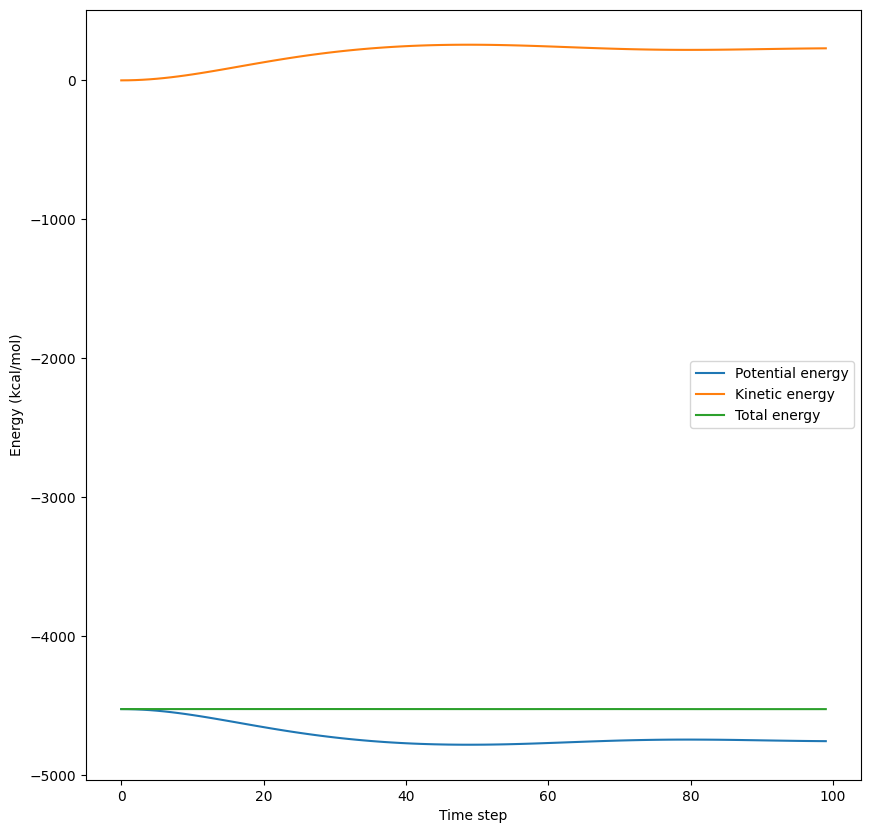

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(np.arange(0, data['n_steps']), potential_energy, label='Potential energy')
ax.plot(np.arange(0, data['n_steps']), kinetic_energy, label='Kinetic energy')
ax.plot(np.arange(0, data['n_steps']), kinetic_energy + potential_energy, label='Total energy')
ax.set_xlabel('Time step')
ax.set_ylabel('Energy (kcal/mol)')
ax.legend()

## Printing and saving the output

As explained in class, the output of the simulation is saved in a plain-text file with ending of .xyz, it will contain all the positions x, y, z of the particles. The file is called using the json file, and it is located in the `data` folder. The same idea occurs for the energy and positions files.

In [44]:
# save the positions in a xyz file
with open(f"data/{data['trajectory_file']}", 'w') as trajectory_file:
    for i in range(0, data['n_steps']):
        trajectory_file.write(f"{data['n_particles']}\n")
        trajectory_file.write(f"Step: {i}, Total energy: {kinetic_energy[i] + potential_energy[i]}\n")
        for j in range(0, data['n_particles']):
            trajectory_file.write(f"Ar {x_s[i][j]} {y_s[i][j]} {z_s[i][j]}\n")

# Parallelizing using MPI

MPI is a message passing interface that allows us to parallelize the code by using multiple nodes into a cluster. In this notebook, we will try to parallelize the Lennard Jones code created before by using MPI over the loop and vectorized versions, and then we will compare the performance of the parallelized code with the serial code.

## Read inputs

Let's initialize all the variables that will be used in the simulation:

In [ ]:
with open('input_2916.json') as f:
    data = json.load(f)
print(f"Loaded {data['n_particles']} particles with {data['n_steps']} timesteps.")

# Read initial positions using numpy, from the json file
with open(f"data/{data['initial_state']}") as initial_state:
    x_i, y_i, z_i = np.genfromtxt(initial_state, unpack=True, max_rows=data['n_particles'])

# Initialize the arrays to store the positions, velocities, and forces
x_s = np.zeros((data['n_steps'], data['n_particles']))
y_s = np.zeros((data['n_steps'], data['n_particles']))
z_s = np.zeros((data['n_steps'], data['n_particles']))
vx_s = np.zeros((data['n_steps'], data['n_particles']))
vy_s = np.zeros((data['n_steps'], data['n_particles']))
vz_s = np.zeros((data['n_steps'], data['n_particles']))
fx_s = np.zeros((data['n_steps'], data['n_particles']))
fy_s = np.zeros((data['n_steps'], data['n_particles']))
fz_s = np.zeros((data['n_steps'], data['n_particles']))

# Initialize the arrays to store the energies
kinetic_energy = np.zeros(data['n_steps'])
potential_energy = np.zeros(data['n_steps'])
temperature = np.zeros(data['n_steps'])

# Add the initial positions to the arrays
x_s[0] = x_i
y_s[0] = y_i
z_s[0] = z_i

Now, initialize the MPI environment:

In [ ]:
comm = MPI.COMM_WORLD  # This is the communicator object
rank = comm.Get_rank() # This is the rank of the current process
size = comm.Get_size() # This is the total number of processes

Now, we will calculate the forces and update the positions and velocities of the particles. To do that, we will use the same functions that we used in the sequential code, but now we will use MPI:

In [ ]:
def lj_force_looping(x, y, z):
    """Compute the Lennard-Jones force."""
    fx = np.zeros(data['n_particles'])
    fy = np.zeros(data['n_particles'])
    fz = np.zeros(data['n_particles'])
    epot = 0.0
    def pbc(r, box_size_by_2):
        """ Minimum image convention
        In this approach, the box have a length 2 * box_size_by_2, and if it is outside the box divided by 2, it is moved to the other side of the box, to avoid wall effects. See: https://www.ucl.ac.uk/~ucfbasc/Theory/pbc-mi.html
        
        It is required to have a cutoff radius lower than box_size_by_2.
        
        :param r: Position of the particle, can be x, y or z.
        :param box_size_by_2: Half of the box size.
        :return: The position of the particle, with the minimum image convention.
        """
        while r > box_size_by_2:
            r -= 2 * box_size_by_2
        while r < -box_size_by_2:
            r += 2 * box_size_by_2
        return r
    # Broadcast the initial positions to all the processes
    comm.Bcast(x, root=0)
    comm.Bcast(y, root=0)
    comm.Bcast(z, root=0)
    # Define variables re-used so many times
    rcut2 = data['r_cut'] * data['r_cut']
    c12 = 4 * data['epsilon'] * data['sigma']**12
    c6 = 4 * data['epsilon'] * data['sigma']**6
    # Loop over all the particles, using a fixed number of particles per process
    for i in range(0, data['n_particles'], size):
        ii = i + rank
        if ii < data['n_particles']:
            for j in range(i+1, data['n_particles']):
                if ii != j:  # Avoid self-interactions
                    dx = pbc(x[ii] - x[j], 0.5 * data['box_size'])
                    dy = pbc(y[ii] - y[j], 0.5 * data['box_size'])
                    dz = pbc(z[ii] - z[j], 0.5 * data['box_size'])
                    rsq = dx*dx + dy*dy + dz*dz
                    
                    if rsq < rcut2:
                        r2_inv = 1.0 / rsq
                        r6_inv = r2_inv * r2_inv * r2_inv
                        epot += r6_inv * (c12 * r6_inv - c6)
                        f = r6_inv * (c12 * r6_inv - 0.5 * c6) * r2_inv
                        fx[ii] += dx * f
                        fy[ii] += dy * f
                        fz[ii] += dz * f
                        # Apply 3rd law of Newton
                        fx[j] -= dx * f
                        fy[j] -= dy * f
                        fz[j] -= dz * f
    # Reduce the forces and the potential energy
    comm.Reduce(fx, fx_s, op=MPI.SUM, root=0)
    comm.Reduce(fy, fy_s, op=MPI.SUM, root=0)
    comm.Reduce(fz, fz_s, op=MPI.SUM, root=0)
    comm.Reduce(epot, potential_energy, op=MPI.SUM, root=0)
    return fx_s, fy_s, fz_s, potential_energy

This implementation of the force MPI is presented on ljmd_parallel_MPI.py file, let's compile it:

In [46]:
! mpirun -np 4 python -m mpi4py ljmd_parallel_MPI.py

Loaded 2916 particles with 10 timesteps.
Loaded 2916 particles with 10 timesteps.
Loaded 2916 particles with 10 timesteps.
Loaded 2916 particles with 10 timesteps.
Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/keneth/Documents/ClassiPyGRB/venv/lib/python3.10/site-packages/mpi4py/__main__.py", line 7, in <module>
    main()
  File "/home/keneth/Documents/ClassiPyGRB/venv/lib/python3.10/site-packages/mpi4py/run.py", line 198, in main
    run_command_line(args)
  File "/home/keneth/Documents/ClassiPyGRB/venv/lib/python3.10/site-packages/mpi4py/run.py", line 47, in run_command_line
    run_path(sys.argv[0], run_name='__main__')
  File "/usr/lib/python3.10/runpy.py", line 289, in run_path
    return _run_module_code(code, init_globals, run_name,
  File "/usr/lib/python3.10/runpy.py",